**Instalisasi PySpark**

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c1a3972d06cf94014d9a0ef01e6b27f1cab11219f696c216b069d3bad33a6d5a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, desc
import matplotlib.pyplot as plt

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("IMDB Analysis").getOrCreate()

**Membaca Data IMDB Top 1000**

In [ ]:
# Ubah path sesuai dengan lokasi file CSV yang Anda simpan
file_path = '/content/imdb_top_1000.csv'

In [ ]:
# Read the CSV file into a DataFrame
df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

In [ ]:
# Show the initial DataFrame
df.show(5)
df.printSchema()

+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----------+
|         Poster_Link|        Series_Title|Released_Year|Certificate|Runtime|               Genre|IMDB_Rating|            Overview|Meta_score|            Director|         Star1|         Star2|        Star3|         Star4|No_of_Votes|      Gross|
+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+--------------+--------------+-------------+--------------+-----------+-----------+
|https://m.media-a...|The Shawshank Red...|         1994|          A|142 min|               Drama|        9.3|Two imprisoned me...|        80|      Frank Darabont|   Tim Robbins|Morgan Freeman|   Bob Gunton|William Sadler|    2343110| 28,341,469|
|https://m.m

**Pembersihan Data**

In [ ]:
from pyspark.sql.functions import col

# Mengecek apakah ada nilai null atau NA pada setiap kolom
for column in df.columns:
    # Mengecek apakah ada nilai null atau NA dalam kolom
    count_null = df.filter(col(column).isNull() | (col(column) == 'NA')).count()

    if count_null > 0:
        print(f"Kolom '{column}' memiliki {count_null} nilai null atau NA.")
    else:
        print(f"Tidak ada nilai null atau NA dalam kolom '{column}'.")


Tidak ada nilai null atau NA dalam kolom 'Poster_Link'.
Tidak ada nilai null atau NA dalam kolom 'Series_Title'.
Tidak ada nilai null atau NA dalam kolom 'Released_Year'.
Kolom 'Certificate' memiliki 101 nilai null atau NA.
Tidak ada nilai null atau NA dalam kolom 'Runtime'.
Tidak ada nilai null atau NA dalam kolom 'Genre'.
Tidak ada nilai null atau NA dalam kolom 'IMDB_Rating'.
Tidak ada nilai null atau NA dalam kolom 'Overview'.
Kolom 'Meta_score' memiliki 156 nilai null atau NA.
Kolom 'Director' memiliki 1 nilai null atau NA.
Tidak ada nilai null atau NA dalam kolom 'Star1'.
Tidak ada nilai null atau NA dalam kolom 'Star2'.
Tidak ada nilai null atau NA dalam kolom 'Star3'.
Tidak ada nilai null atau NA dalam kolom 'Star4'.
Tidak ada nilai null atau NA dalam kolom 'No_of_Votes'.
Kolom 'Gross' memiliki 169 nilai null atau NA.


In [ ]:
df_clean = df.na.drop(subset=["Certificate", "Meta_score", "No_of_Votes", "Gross", "Director"])

In [ ]:
# Mengecek apakah ada nilai null atau NA pada setiap kolom
for column in df_clean.columns:
    # Mengecek apakah ada nilai null atau NA dalam kolom
    count_null = df_clean.filter(col(column).isNull() | (col(column) == 'NA')).count()

    if count_null > 0:
        print(f"Kolom '{column}' masih memiliki {count_null} nilai null atau NA.")
    else:
        print(f"Tidak ada nilai null atau NA dalam kolom '{column}'.")

Tidak ada nilai null atau NA dalam kolom 'Poster_Link'.
Tidak ada nilai null atau NA dalam kolom 'Series_Title'.
Tidak ada nilai null atau NA dalam kolom 'Released_Year'.
Tidak ada nilai null atau NA dalam kolom 'Certificate'.
Tidak ada nilai null atau NA dalam kolom 'Runtime'.
Tidak ada nilai null atau NA dalam kolom 'Genre'.
Tidak ada nilai null atau NA dalam kolom 'IMDB_Rating'.
Tidak ada nilai null atau NA dalam kolom 'Overview'.
Tidak ada nilai null atau NA dalam kolom 'Meta_score'.
Tidak ada nilai null atau NA dalam kolom 'Director'.
Tidak ada nilai null atau NA dalam kolom 'Star1'.
Tidak ada nilai null atau NA dalam kolom 'Star2'.
Tidak ada nilai null atau NA dalam kolom 'Star3'.
Tidak ada nilai null atau NA dalam kolom 'Star4'.
Tidak ada nilai null atau NA dalam kolom 'No_of_Votes'.
Tidak ada nilai null atau NA dalam kolom 'Gross'.


In [ ]:
df_clean.write.csv('/content/imdbdtaclean1000.csv', header=True, mode="overwrite")

**Analisis Data**

Membaca file yang sudah dibersikan

In [ ]:
# Membaca data dari file CSV
file_path = "/content/imdbdtaclean1000.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# Mendaftarkan DataFrame sebagai tabel sementara dengan nama 'imdb'
df.createOrReplaceTempView("imdb")

***1. Rekomendasi Movies Berdasarkan Rating ***

Melihat Jumlah Movie yang memiliki rating sama dari yang tertinggi

In [ ]:
result = spark.sql("SELECT IMDB_Rating, COUNT(*) as count FROM imdb GROUP BY IMDB_Rating ORDER BY IMDB_Rating DESC")
result.show()

+-----------+-----+
|IMDB_Rating|count|
+-----------+-----+
|        9.3|    1|
|        9.2|    1|
|        9.0|    3|
|        8.9|    3|
|        8.8|    5|
|        8.7|    5|
|        8.6|   11|
|        8.5|   19|
|        8.4|   20|
|        8.3|   33|
|        8.2|   32|
|        8.1|   72|
|        8.0|   97|
|        7.9|   77|
|        7.8|  107|
|        7.7|  121|
|        7.6|  107|
+-----------+-----+



Mengetahui judul film-film yang memiliki rating tertentu

In [ ]:
#Series apa saja yang memiliki rating 8.8
result_with_titles = spark.sql("SELECT Series_Title, IMDB_Rating FROM imdb WHERE IMDB_Rating = 8.8")
result_with_titles.show()

+--------------------+-----------+
|        Series_Title|IMDB_Rating|
+--------------------+-----------+
|           Inception|        8.8|
|          Fight Club|        8.8|
|The Lord of the R...|        8.8|
|        Forrest Gump|        8.8|
|Il buono, il brut...|        8.8|
+--------------------+-----------+



*** 2. Rekomendasi Film Terbaik pada setiap tahun ***

Daftar film teratas untuk setiap tahun yang diurutkan berdasarkan tahun rilisnya.

In [ ]:
top_movies = spark.sql("""
    SELECT Released_Year, Series_Title, IMDB_Rating
    FROM (
        SELECT Released_Year, Series_Title, IMDB_Rating,
               ROW_NUMBER() OVER (PARTITION BY Released_Year ORDER BY IMDB_Rating DESC) as rank
        FROM imdb
    )
    WHERE rank = 1
    ORDER BY Released_Year
""")
top_movies.show()


+-------------+--------------------+-----------+
|Released_Year|        Series_Title|IMDB_Rating|
+-------------+--------------------+-----------+
|         1930|All Quiet on the ...|        8.0|
|         1931|         City Lights|        8.5|
|         1933|           King Kong|        7.9|
|         1934|It Happened One N...|        8.1|
|         1936|        Modern Times|        8.5|
|         1938|The Adventures of...|        7.9|
|         1939|Mr. Smith Goes to...|        8.1|
|         1940|             Rebecca|        8.1|
|         1941|        Citizen Kane|        8.3|
|         1942|          Casablanca|        8.5|
|         1944|    Double Indemnity|        8.3|
|         1946|The Best Years of...|        8.0|
|         1948|The Treasure of t...|        8.2|
|         1949|       The Third Man|        8.1|
|         1950|       All About Eve|        8.2|
|         1951|     Ace in the Hole|        8.1|
|         1952| Singin' in the Rain|        8.3|
|         1953|From 

Melihat semua judul film yang dirilis pada tahun tertentu, diurutkan berdasarkan peringkat IMDb dari yang tertinggi ke terendah.

In [ ]:
#Melihat judul film yang di risis pada tahun 1957 berdasarkan rating tertinggi
top_movies_1957 = spark.sql("""
    SELECT Series_Title, IMDB_Rating
    FROM imdb
    WHERE Released_Year = 1957
    ORDER BY IMDB_Rating DESC
""")
top_movies_1957.show()

+--------------------+-----------+
|        Series_Title|IMDB_Rating|
+--------------------+-----------+
|        12 Angry Men|        9.0|
|The Bridge on the...|        8.1|
+--------------------+-----------+



**3. Rekomendasi Film terbaik Berdasarkan Genrenya**

menghitung rata-rata peringkat IMDb untuk setiap genre film.


In [ ]:
avg_rating_genre = spark.sql("""
    SELECT Genre, AVG(IMDB_Rating) as avg_rating
    FROM imdb
    GROUP BY Genre
    ORDER BY avg_rating DESC
""")
avg_rating_genre.show()


+--------------------+-----------------+
|               Genre|       avg_rating|
+--------------------+-----------------+
|Crime, Mystery, T...|              8.5|
|      Horror, Sci-Fi|              8.4|
|       Drama, Horror|              8.4|
|      Action, Sci-Fi|              8.4|
| Drama, Mystery, War|8.350000000000001|
|             Western|             8.35|
|Comedy, Musical, ...|              8.3|
|Crime, Drama, Sci-Fi|              8.3|
|Mystery, Romance,...|              8.3|
|Adventure, Myster...|              8.3|
|Crime, Drama, Fan...|             8.25|
|Drama, Family, Sport|             8.25|
|Action, Adventure...|            8.225|
|        Crime, Drama|8.205263157894738|
|Comedy, Music, Ro...|              8.2|
| Drama, Fantasy, War|              8.2|
|Adventure, Drama,...|              8.2|
|Action, Drama, Sport|              8.2|
|Action, Adventure...|8.199999999999998|
|   Action, Adventure|8.180000000000001|
+--------------------+-----------------+
only showing top

Menampilkan visualisasi untuk rating film tertinggi berdasarkan genre

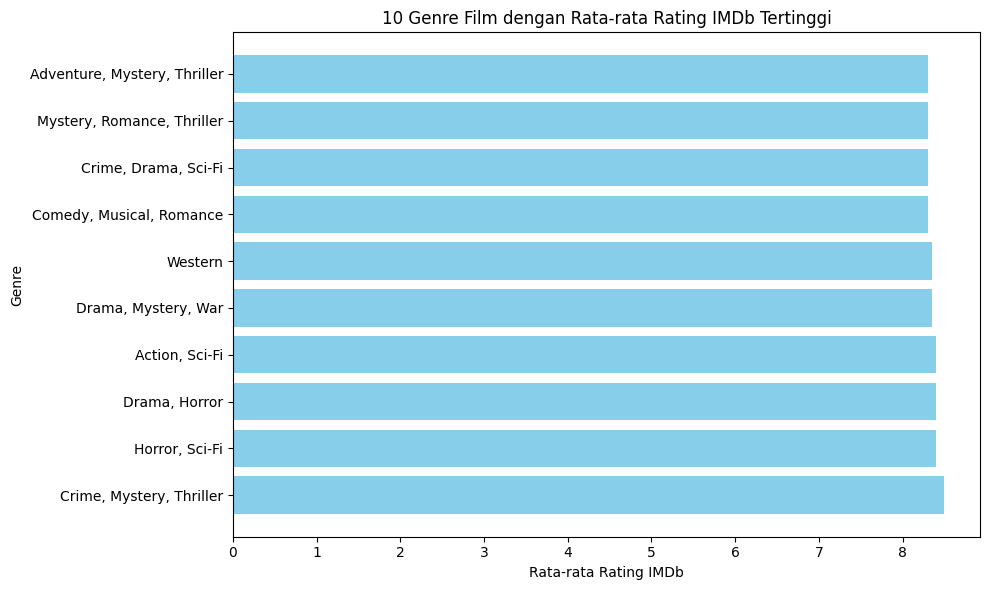

In [ ]:
import matplotlib.pyplot as plt

# Mengambil data dari DataFrame Spark dan mengonversinya ke Pandas DataFrame
avg_rating_genre_pd = avg_rating_genre.toPandas()
# Mengurutkan data berdasarkan rata-rata rating IMDb secara menurun
avg_rating_genre_pd = avg_rating_genre_pd.sort_values(by='avg_rating', ascending=False)
# Memilih 10 genre dengan rata-rata rating IMDb tertinggi
top_10_genre = avg_rating_genre_pd.head(10)

# Menampilkan diagram batang horizontal untuk 10 genre teratas
plt.figure(figsize=(10, 6))
plt.barh(top_10_genre['Genre'], top_10_genre['avg_rating'], color='skyblue')
plt.xlabel('Rata-rata Rating IMDb')
plt.ylabel('Genre')
plt.title('10 Genre Film dengan Rata-rata Rating IMDb Tertinggi')
plt.tight_layout()  # Menyesuaikan tata letak agar tidak tumpang tindih
plt.show()

Memberikan Rekomendasi Film Berdasarkan Genere yang diinginkan

In [ ]:
# Definisikan kata kunci genre yang ingin dicari
genre_keyword = "Crime"

# Query SQL untuk mencari film berdasarkan genre yang mengandung kata kunci tertentu
query = f"""
    SELECT *
    FROM imdb
    WHERE Genre LIKE '%{genre_keyword}%'
"""

# Jalankan query dan tampilkan hasilnya
action_movies = spark.sql(query)
action_movies.show()


+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+-----------------+--------------------+------------------+--------------------+-----------+-----------+
|         Poster_Link|        Series_Title|Released_Year|Certificate|Runtime|               Genre|IMDB_Rating|            Overview|Meta_score|            Director|            Star1|               Star2|             Star3|               Star4|No_of_Votes|      Gross|
+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+-----------------+--------------------+------------------+--------------------+-----------+-----------+
|https://m.media-a...|       The Godfather|         1972|          A|175 min|        Crime, Drama|        9.2|An organized crim...|       100|Francis Ford Coppola|    Marlon Brando|           Al Paci